### Training Notebook

Author: Antony Sikorski

In this notebook we do a little bit of setup, train the model, and take a look at the loss. 

If you get any package error, install the requirements please: 

In [1]:
#!pip install -r requirements.txt

In [2]:
# libraries 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
import json
from collections import Counter, defaultdict
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import StepLR
from jaxtyping import Int, Float
import tqdm
import transformers
import transformer_lens
from muutils.misc import shorten_numerical_to_str

#imports from files
from text_dataset import TextDataset
from model import GPTConfig, GPT

c:\Python\Python_3_10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Python\Python_3_10\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Let's check if you have a GPU on your computer that you can run this on. That could make this process significantly faster, but you could also run out of memory (Cuda Out Of Memory error). If you don't have torch with CUDA, don't worry about this, you can just use your CPU. 

In [3]:
if(torch.cuda.is_available() == True):
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 3060 Laptop GPU


I can use my laptop GPU, which is good news! 

In [4]:
# necessary auto-reload for development on local machine
%load_ext autoreload
%autoreload 2

### DataSet

Let's use the TinyStories dataset, a well known dataset that gained fame when small yet still coherent models were trained on it. The dataset is made from a bunch of GPT generated children's stories, thus it does not have much diversity in content and should theoretically be pretty easy to learn. 

We only use a small chunk of the data for the sake of making training easy on a laptop. 

In [7]:
# grabbing the whole dataset
text_data = load_dataset("roneneldan/TinyStories")

Repo card metadata block was not found. Setting CardData to empty.


In [8]:
#let's only use the training data
text_data = text_data["train"]

# and let's only use the first story_num stories 
story_num = 1000
text_data = text_data[:story_num]

#what does a story look like? 
print("\n Sample story (story #8):")
text_data['text'][7]


 Sample story (story #8):


'Once upon a time, in a peaceful town, there lived a little boy named Tim. Tim loved to run and play outside. One day, Tim saw a race in the park. He was excited and wanted to join the race.\n\nTim went to his friend, Sarah, and said, "Let\'s start the race!" Sarah smiled and said, "Yes, let\'s go!" They lined up with the other kids and waited for the race to begin. When they heard the word "Go!", they started running as fast as they could.\n\nTim and Sarah ran with all their speed, laughing and having fun. They could feel the wind in their hair as they raced to the finish line. In the end, Tim won the race and Sarah came in second. They were both so happy and proud of themselves. They celebrated with their friends and had a great day at the park.'

Okay now let's turn our dataset into a big long string, and check how long it is: 

In [9]:
text_data = "\n\n".join(text_data['text'])
len(text_data)

76060

### Training 

Here we train the model! First, we define our training loop. Our dataset is saved on the CPU, but everything else will be on GPU. We will move our batches from CPU to GPU. This slows things down, but is worth the extra compute because it enables us to use more data.  

In [10]:
def train(
	model: GPT,
	text: str,
	optimizer: torch.optim.Optimizer,
	scheduler: torch.optim.lr_scheduler._LRScheduler,
	device: torch.device = ("cuda" if torch.cuda.is_available() else "cpu"),
	batch_size: int = 8,
	max_batches: int|None = None,
	print_interval: int = 100,
	epochs: int = 1,
) -> tuple[GPT, list[dict]]:
	
	# move model to device
	print(f"moving model to device: {device}")
	model.to(device)
	
	# set up data
	print(f"setting up dataset from text of length {len(text)}")
	dataset: TextDataset = TextDataset(
		text=text, 
		tokenizer=model.tokenizer, 
		n_context=model.config.n_context,
	)
	print(f"\tset up dataset with {len(dataset)} examples, example lengths: {dataset.example_lengths()}")

	print(f"setting up dataloader from {len(dataset)} examples")
	dataloader: DataLoader = DataLoader(
		dataset, 
		batch_size=batch_size, 
		shuffle=True,
		pin_memory=True,
	)
	print(f"\tset up dataloader with {len(dataloader)} batches of size {batch_size}")

	# set up training loop
	print("training...")
	training_records: list[dict] = list()
	model.train()

	for epoch in range(epochs):
		print(f"Epoch {epoch + 1}/{epochs}\n")
		i: int; batch: Float[torch.Tensor, "batch n_ctx"]
		for i, batch in tqdm.tqdm(
			enumerate(dataloader),
			total=len(dataloader),
			desc="Training",
		):
			# move batch to device
			batch = batch.to(device)
			
			# break if we've reached the maximum number of batches
			if max_batches is not None and i > max_batches:
				break

			# forward pass
			logits, loss = model(
				batch[:, :-1],
				targets=batch[:, 1:], # the targets are just the input, offset by one
			)

			# backward pass
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			# record progress
			training_records.append({
				"batch": i,
				"loss": loss.item(),
			})

			if i % print_interval == 0:
				print(f"Batch {i}, Loss: {loss.item()}\n")

		scheduler.step()
		print(f"Updated learning rate to: {optimizer.param_groups[0]['lr']}")

	return model, training_records

Now let's configure (define params for) our own model (which will be small) and do some setup before we train it: 

In [11]:
# using the GPT2 tokenizer, and making sure it has the same vocab size as the model
TOKENIZER: transformers.PreTrainedTokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
print(f"{TOKENIZER.vocab_size = } \n")


# set up a config for a small model
CONFIG: GPTConfig = GPTConfig(
	d_model=32,
	d_vocab=50257,
	n_context=128,
	n_blocks=2,
	n_head=4,
    tokenizer=TOKENIZER,
)

# not the most necessary check but it felt good to do
assert(TOKENIZER.vocab_size == GPTConfig().d_vocab)

# initialize the model
MODEL: GPT = GPT(CONFIG)

#two ways of printing number of model params
print("Muutils rounded model params: ")
print(f"MODEL.n_params = {shorten_numerical_to_str(MODEL.n_params)} \n")
print("Full model params: ")
print(f"MODEL.n_params = {MODEL.n_params}")

# choice of optimizer
OPTIMIZER: torch.optim.Optimizer = torch.optim.AdamW(MODEL.parameters(), lr=1e-2)
#OPTIMIZER: torch.optim.Optimizer = torch.optim.SGD(MODEL.parameters(), lr=1e-1)
# Initialize the learning rate scheduler
SCHEDULER: StepLR = StepLR(OPTIMIZER, step_size=100, gamma=0.1)

TOKENIZER.vocab_size = 50257 

Muutils rounded model params: 
MODEL.n_params = 3.2M 

Full model params: 
MODEL.n_params = 3246016


In [12]:
print(TOKENIZER)

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}


Let's train the model! 

In [13]:
MODEL_TRAINED, training_history = train(
	model=MODEL,
	text=text_data,
	optimizer=OPTIMIZER,
    scheduler = SCHEDULER,
	device=("cuda" if torch.cuda.is_available() else "cpu"),
	batch_size=10,
	max_batches=None,
	print_interval=100,
	epochs= 10,
)


moving model to device: cuda


Token indices sequence length is longer than the specified maximum sequence length for this model (18985 > 1024). Running this sequence through the model will result in indexing errors


setting up dataset from text of length 76060
	set up dataset with 147 examples, example lengths: Counter({129: 147})
setting up dataloader from 147 examples
	set up dataloader with 15 batches of size 10
training...
Epoch 1/10



Training:  13%|█▎        | 2/15 [00:02<00:15,  1.23s/it]

Batch 0, Loss: 11.006990432739258



Training: 100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


Updated learning rate to: 0.01
Epoch 2/10



Training:  13%|█▎        | 2/15 [00:00<00:01, 10.44it/s]

Batch 0, Loss: 5.95828914642334



Training: 100%|██████████| 15/15 [00:01<00:00, 10.41it/s]


Updated learning rate to: 0.01
Epoch 3/10



Training:  13%|█▎        | 2/15 [00:00<00:01, 10.32it/s]

Batch 0, Loss: 5.598705768585205



Training: 100%|██████████| 15/15 [00:01<00:00, 10.37it/s]


Updated learning rate to: 0.01
Epoch 4/10



Training:  13%|█▎        | 2/15 [00:00<00:01, 10.40it/s]

Batch 0, Loss: 5.2930426597595215



Training: 100%|██████████| 15/15 [00:01<00:00, 10.40it/s]


Updated learning rate to: 0.01
Epoch 5/10



Training:  13%|█▎        | 2/15 [00:00<00:01, 10.30it/s]

Batch 0, Loss: 5.027599334716797



Training: 100%|██████████| 15/15 [00:01<00:00, 10.28it/s]


Updated learning rate to: 0.01
Epoch 6/10



Training:  13%|█▎        | 2/15 [00:00<00:01, 10.13it/s]

Batch 0, Loss: 4.430612087249756



Training: 100%|██████████| 15/15 [00:01<00:00, 10.28it/s]


Updated learning rate to: 0.01
Epoch 7/10



Training:  13%|█▎        | 2/15 [00:00<00:01, 10.09it/s]

Batch 0, Loss: 4.013110160827637



Training: 100%|██████████| 15/15 [00:01<00:00, 10.33it/s]


Updated learning rate to: 0.01
Epoch 8/10



Training:  13%|█▎        | 2/15 [00:00<00:01, 10.35it/s]

Batch 0, Loss: 3.708815097808838



Training: 100%|██████████| 15/15 [00:01<00:00, 10.26it/s]


Updated learning rate to: 0.01
Epoch 9/10



Training:  13%|█▎        | 2/15 [00:00<00:01, 10.37it/s]

Batch 0, Loss: 3.540332078933716



Training: 100%|██████████| 15/15 [00:01<00:00, 10.33it/s]


Updated learning rate to: 0.01
Epoch 10/10



Training:  13%|█▎        | 2/15 [00:00<00:01, 10.20it/s]

Batch 0, Loss: 3.257321834564209



Training: 100%|██████████| 15/15 [00:01<00:00, 10.29it/s]

Updated learning rate to: 0.01


Now we save our trained model: 

In [14]:
MODEL_TRAINED.save("C:/Users/anton/Desktop/Mines/DSCI _575_AdvML/Programming_Project/saved_models/model.zanj")

### Analysis of Loss

First, let's take a quick look at our loss: 

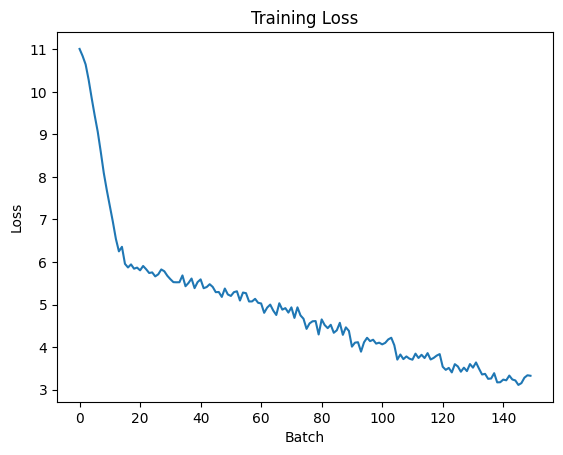

In [16]:
#plot loss over epochs
losses = [record["loss"] for record in training_history]
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

It appears that it shakily decreased throughout the training run.